In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

In [2]:
sns.set()

In [3]:
drowings = np.loadtxt("../data/drowning.txt")
drowings;

In [4]:
data = np.loadtxt("../data/factory.txt")
data

array([[ 83., 117., 101., 105.,  79.,  57.],
       [ 92., 109.,  93., 119.,  97.,  92.],
       [ 92., 114.,  92., 116., 103., 104.],
       [ 46., 104.,  86., 102.,  79.,  77.],
       [ 67.,  87.,  67., 116.,  92., 100.]])

## Pooled model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu, \sigma) \\
\mu &\sim \mathcal{N}(92, 100) \\
\sigma &\sim |\mathcal{N}|(0, 100) \\
\end{align*}


In [5]:
data_vec = data.ravel()
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [6]:
pd.Series(data_vec).describe()

count     30.000000
mean      92.933333
std       18.001788
min       46.000000
25%       83.750000
50%       92.500000
75%      104.000000
max      119.000000
dtype: float64

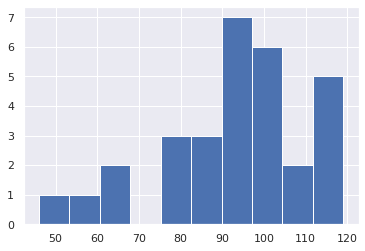

In [7]:
plt.hist(data_vec);

<AxesSubplot:>

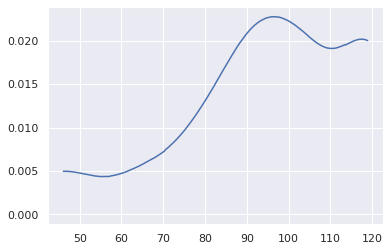

In [8]:
az.plot_kde(data_vec)

In [9]:
(120 - 92.5)/3

9.166666666666666

In [10]:
import scipy
pd.DataFrame(scipy.stats.halfnorm.rvs(size=1000, scale=15)).describe()

0
count  1000.000000
mean     11.752343
std       8.821060
min       0.036501
25%       4.560479
50%      10.107784
75%      17.194530
max      50.550398

In [11]:
with pm.Model() as factory_pooled:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=data_vec)
    trace_pooled = pm.sample(10_000)

/tmp/ipykernel_53155/3746291418.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [12]:
az.summary(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu   92.897  3.195  86.814   98.846      0.018    0.013   31001.0   25778.0   
std  18.243  2.412  14.113   22.835      0.015    0.010   27905.0   25437.0   

     r_hat  
mu     1.0  
std    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'std'}>], dtype=object)

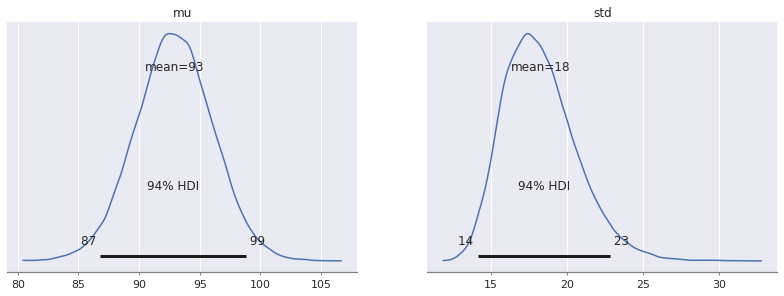

In [13]:
az.plot_posterior(trace_pooled)

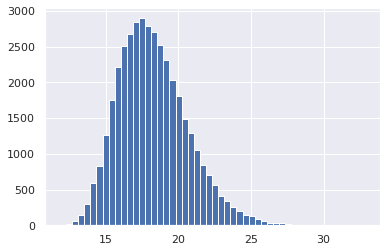

In [14]:
plt.hist(trace_pooled["std"], bins=50);

In [15]:
#with factory_pooled:
az.waic(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -130.79     4.39
p_waic        1.96        -

There has been a warning during the calculation. Please check the results.

## Separate model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [16]:
#data.ravel(order="F")
#np.tile(np.arange(groups), meas)

groups = data.shape[1] # number of groups
meas = data.shape[0] # number of measurements per group
data_vec = data.ravel()
group_vec = np.tile(np.arange(groups), meas)

In [17]:
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [18]:
group_vec

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5])

In [19]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [20]:
data.std(axis=0, ddof=1)

array([19.63415392, 11.81947545, 12.79453008,  7.56967635, 10.77032961,
       19.22238279])

In [21]:
with pm.Model() as factory_separate:
    group_mu = pm.Normal('group_mu', mu=92.5, sd=100, shape=groups)
    group_std = pm.HalfNormal('group_std', sd=100, shape=groups)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=group_std[group_vec], observed=data_vec)
    trace_separate = pm.sample(10_000)


/tmp/ipykernel_53155/1392549784.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_separate = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.482  13.967   49.335  101.778      0.096    0.071   26750.0   
group_mu[1]   105.969   9.182   88.722  122.773      0.084    0.059   17620.0   
group_mu[2]    87.836   9.662   69.172  105.512      0.081    0.061   19692.0   
group_mu[3]   111.548   5.974  100.657  122.904      0.049    0.035   20187.0   
group_mu[4]    90.079   8.419   74.289  105.365      0.066    0.047   23114.0   
group_mu[5]    86.151  14.428   59.539  113.822      0.122    0.086   18357.0   
group_std[0]   28.800  15.415   10.660   55.345      0.112    0.080   25786.0   
group_std[1]   18.223  10.850    6.299   36.039      0.096    0.069   20352.0   
group_std[2]   19.426  11.224    6.766   37.889      0.092    0.067   22625.0   
group_std[3]   11.683   7.191    4.099   23.315      0.060    0.042   22586.0   
group_std[4]   16.479   9.840    5.595   32.240      0.078    0.055   23988.0   
group_std[5]   28.708  15.657   10.343   56.151      0.124    0.088   21702.0   

              ess_tail  r_hat  
group_mu[0]    17929.0    1.0  
group_mu[1]    13062.0    1.0  
group_mu[2]    14983.0    1.0  
group_mu[3]    15166.0    1.0  
group_mu[4]    17116.0    1.0  
group_mu[5]    14346.0    1.0  
group_std[0]   20460.0    1.0  
group_std[1]   14228.0    1.0  
group_std[2]   16584.0    1.0  
group_std[3]   16621.0    1.0  
group_std[4]   17777.0    1.0  
group_std[5]   17598.0    1.0

In [23]:
#plt.hist(trace_separate["group_std"][:, 5], bins=50);
px.histogram(trace_separate["group_std"][:, 5])#, bins=50);

<AxesSubplot:title={'center':'x'}>

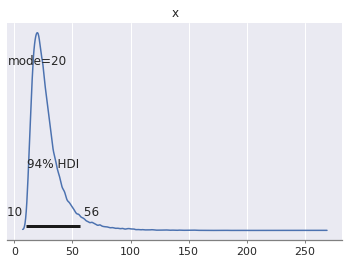

In [24]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mode')

<AxesSubplot:title={'center':'x'}>

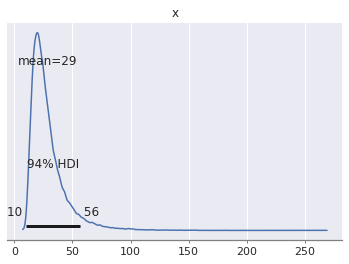

In [25]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mean')

In [26]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.482  13.967   49.335  101.778      0.096    0.071   26750.0   
group_mu[1]   105.969   9.182   88.722  122.773      0.084    0.059   17620.0   
group_mu[2]    87.836   9.662   69.172  105.512      0.081    0.061   19692.0   
group_mu[3]   111.548   5.974  100.657  122.904      0.049    0.035   20187.0   
group_mu[4]    90.079   8.419   74.289  105.365      0.066    0.047   23114.0   
group_mu[5]    86.151  14.428   59.539  113.822      0.122    0.086   18357.0   
group_std[0]   28.800  15.415   10.660   55.345      0.112    0.080   25786.0   
group_std[1]   18.223  10.850    6.299   36.039      0.096    0.069   20352.0   
group_std[2]   19.426  11.224    6.766   37.889      0.092    0.067   22625.0   
group_std[3]   11.683   7.191    4.099   23.315      0.060    0.042   22586.0   
group_std[4]   16.479   9.840    5.595   32.240      0.078    0.055   23988.0   
group_std[5]   28.708  15.657   10.343   56.151      0.124    0.088   21702.0   

              ess_tail  r_hat  
group_mu[0]    17929.0    1.0  
group_mu[1]    13062.0    1.0  
group_mu[2]    14983.0    1.0  
group_mu[3]    15166.0    1.0  
group_mu[4]    17116.0    1.0  
group_mu[5]    14346.0    1.0  
group_std[0]   20460.0    1.0  
group_std[1]   14228.0    1.0  
group_std[2]   16584.0    1.0  
group_std[3]   16621.0    1.0  
group_std[4]   17777.0    1.0  
group_std[5]   17598.0    1.0

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [27]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [28]:
data.std()

17.699215299617727

In [29]:
with pm.Model() as factory_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=groups)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=std, observed=data_vec)
    trace_hierarchical = pm.sample(10_000)

/tmp/ipykernel_53155/3766789020.py:11: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6852283164173831, but should be close to 0.8. Try to increase the number of tuning steps.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
az.summary(trace_hierarchical)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    93.099  7.967  78.389  107.886      0.061    0.045   19001.0   
group_mu[0]    79.993  6.781  67.704   93.058      0.091    0.067    5744.0   
group_mu[1]   103.031  6.615  90.838  115.277      0.110    0.078    3516.0   
group_mu[2]    89.077  6.121  77.209  100.346      0.046    0.032   17528.0   
group_mu[3]   107.159  7.005  92.410  118.939      0.140    0.099    2688.0   
group_mu[4]    90.745  6.058  79.298  102.080      0.047    0.033   16223.0   
group_mu[5]    87.692  6.194  76.034   99.296      0.052    0.037   13754.0   
hyper_mu_std   15.774  9.022   3.301   30.731      0.129    0.091    1594.0   
std            15.281  2.481  11.114   19.846      0.081    0.068    2173.0   

              ess_tail  r_hat  
hyper_mu_mu    19781.0    1.0  
group_mu[0]     6204.0    1.0  
group_mu[1]      792.0    1.0  
group_mu[2]    15851.0    1.0  
group_mu[3]      608.0    1.0  
group_mu[4]    13826.0    1.0  
group_mu[5]    20479.0    1.0  
hyper_mu_std     348.0    1.0  
std              770.0    1.0

In [31]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [32]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [33]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [34]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [35]:
az.summary(trace_hierarchical)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    93.099  7.967  78.389  107.886      0.061    0.045   19001.0   
group_mu[0]    79.993  6.781  67.704   93.058      0.091    0.067    5744.0   
group_mu[1]   103.031  6.615  90.838  115.277      0.110    0.078    3516.0   
group_mu[2]    89.077  6.121  77.209  100.346      0.046    0.032   17528.0   
group_mu[3]   107.159  7.005  92.410  118.939      0.140    0.099    2688.0   
group_mu[4]    90.745  6.058  79.298  102.080      0.047    0.033   16223.0   
group_mu[5]    87.692  6.194  76.034   99.296      0.052    0.037   13754.0   
hyper_mu_std   15.774  9.022   3.301   30.731      0.129    0.091    1594.0   
std            15.281  2.481  11.114   19.846      0.081    0.068    2173.0   

              ess_tail  r_hat  
hyper_mu_mu    19781.0    1.0  
group_mu[0]     6204.0    1.0  
group_mu[1]      792.0    1.0  
group_mu[2]    15851.0    1.0  
group_mu[3]      608.0    1.0  
group_mu[4]    13826.0    1.0  
group_mu[5]    20479.0    1.0  
hyper_mu_std     348.0    1.0  
std              770.0    1.0

In [36]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [37]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [38]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [39]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [40]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [41]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)